# **Clustering based Course Recommender System**

For each user group, we can come up with a list of popular courses. For example, for the machine learning user cluster/learning group, we can count the most frequently enrolled courses, which are very likely to be the most popular and good machine learning courses because they are enrolled by many users who are interested in machine learning. 

If we know a user belongs to the machine learning group, we may recommend the most enrolled courses to them and it is very likely the user will be interested in them.

Aim:

* Perform k-means clustering on the original user profile feature vectors
* Apply PCA (Principle Component Analysis ) on user profile feature vectors to reduce dimensions
* Perform k-means clustering on the PCA transformed main components
* Generate course recommendations based on other group members' enrollment history

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
# random state
rs = 123

### Load the user profile dataset
Let's first load the original user profile feature vectors:


In [3]:
user_profile_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/user_profile.csv"
user_profile_df = pd.read_csv(user_profile_url)
user_profile_df.head()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,2,52.0,14.0,6.0,43.0,3.0,33.0,0.0,29.0,41.0,2.0,18.0,34.0,9.0,6.0
1,4,40.0,2.0,4.0,28.0,0.0,14.0,0.0,20.0,24.0,0.0,6.0,6.0,0.0,2.0
2,5,24.0,8.0,18.0,24.0,0.0,30.0,0.0,22.0,14.0,2.0,14.0,26.0,4.0,6.0
3,7,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,8,6.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0


In [4]:
user_profile_df.shape

(33901, 15)

we can then list the feature names, they are the user interested topics (course genres):


In [5]:
feature_names = list(user_profile_df.columns[1:])
print(*feature_names, sep=', ')

Database, Python, CloudComputing, DataAnalysis, Containers, MachineLearning, ComputerVision, DataScience, BigData, Chatbot, R, BackendDev, FrontendDev, Blockchain


As we can see from the user profile dataset, we have about 33K unique users with interests in areas like ``Database``, ``Python``, ``CloudComputing``, etc. Then, let's check the  summary statistics for each feature.


In [6]:
user_profile_df.describe()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
count,3.390100e+04,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000
mean,1.064064e+06,5.518569,3.493791,2.307100,3.624701,0.998938,3.048022,0.001770,5.087343,4.750450,0.462995,1.017433,2.269461,0.315802,0.986844
std,4.972578e+05,7.611941,4.227254,3.841858,4.760135,2.351764,4.624004,0.072846,5.230697,7.216228,1.055186,2.342532,4.310752,1.363462,1.950585
min,2.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.813480e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.043907e+06,3.000000,3.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.451159e+06,9.000000,6.000000,3.000000,6.000000,0.000000,3.000000,0.000000,9.000000,6.000000,0.000000,0.000000,3.000000,0.000000,2.000000
max,2.103039e+06,63.000000,18.000000,38.000000,48.000000,15.000000,39.000000,3.000000,32.000000,54.000000,6.000000,18.000000,54.000000,15.000000,12.000000


The original user profile feature vector is not normalized, which may cause issues when we perform clustering and Principal component analysis (PCA), therefor we standardize the data.


In [7]:
# Use StandardScaler to make each feature with mean 0, standard deviation 1
scaler = StandardScaler()
user_profile_df[feature_names] = scaler.fit_transform(user_profile_df[feature_names])
print(f"mean {user_profile_df[feature_names].mean()} and standard deviation{user_profile_df[feature_names].std()}")

mean Database          -3.353495e-17
Python            -5.700942e-17
CloudComputing    -3.521170e-17
DataAnalysis      -7.671120e-17
Containers         3.353495e-18
MachineLearning    3.688845e-17
ComputerVision    -1.509073e-17
DataScience       -1.676748e-17
BigData            6.706990e-17
Chatbot           -6.874665e-17
R                  4.233788e-17
BackendDev         1.383317e-17
FrontendDev        5.051202e-17
Blockchain        -5.281755e-17
dtype: float64 and standard deviationDatabase           1.000015
Python             1.000015
CloudComputing     1.000015
DataAnalysis       1.000015
Containers         1.000015
MachineLearning    1.000015
ComputerVision     1.000015
DataScience        1.000015
BigData            1.000015
Chatbot            1.000015
R                  1.000015
BackendDev         1.000015
FrontendDev        1.000015
Blockchain         1.000015
dtype: float64


In [8]:
user_profile_df.describe()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
count,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04
mean,1.064064e+06,-3.353495e-17,-5.700942e-17,-3.521170e-17,-7.671120e-17,3.353495e-18,3.688845e-17,-1.509073e-17,-1.676748e-17,6.706990e-17,-6.874665e-17,4.233788e-17,1.383317e-17,5.051202e-17,-5.281755e-17
std,4.972578e+05,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00
min,2.000000e+00,-7.249991e-01,-8.265040e-01,-6.005256e-01,-7.614816e-01,-4.247674e-01,-6.591835e-01,-2.429612e-02,-9.726080e-01,-6.583107e-01,-4.387873e-01,-4.343370e-01,-5.264730e-01,-2.316212e-01,-5.059295e-01
25%,6.813480e+05,-7.249991e-01,-8.265040e-01,-6.005256e-01,-7.614816e-01,-4.247674e-01,-6.591835e-01,-2.429612e-02,-9.726080e-01,-6.583107e-01,-4.387873e-01,-4.343370e-01,-5.264730e-01,-2.316212e-01,-5.059295e-01
50%,1.043907e+06,-3.308757e-01,-1.168130e-01,-6.005256e-01,-1.312380e-01,-4.247674e-01,-6.591835e-01,-2.429612e-02,-3.990622e-01,-3.811535e-01,-4.387873e-01,-4.343370e-01,-5.264730e-01,-2.316212e-01,-5.059295e-01
75%,1.451159e+06,4.573712e-01,5.928781e-01,1.803581e-01,4.990056e-01,-4.247674e-01,-1.038556e-02,-2.429612e-02,7.480294e-01,1.731609e-01,-4.387873e-01,-4.343370e-01,1.694715e-01,-2.316212e-01,5.194189e-01
max,2.103039e+06,7.551593e+00,3.431642e+00,9.290667e+00,9.322416e+00,5.953517e+00,7.775190e+00,4.115884e+01,5.145214e+00,6.824934e+00,5.247500e+00,7.249771e+00,1.200053e+01,1.076995e+01,5.646161e+00


The normalized user profile features are: 


In [10]:
features = user_profile_df.loc[:, user_profile_df.columns != 'user']
features.head()

,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,6.106474,2.485388,0.961242,8.272010,0.850889,6.477594,-0.024296,4.571668,5.023412,1.456642,7.249771,7.360899,6.369323,2.570116
1,4.529980,-0.353377,0.440653,5.120792,-0.424767,2.368540,-0.024296,2.851031,2.667576,-0.438787,2.127032,0.865416,-0.231621,0.519419
2,2.427988,1.066006,4.084776,4.280467,-0.424767,5.828796,-0.024296,3.233395,1.281790,1.456642,5.542191,5.505047,2.702132,2.570116
3,-0.462250,-0.826504,-0.600526,-0.341319,-0.424767,-0.659184,-0.024296,-0.972608,-0.381153,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930
4,0.063248,-0.826504,-0.600526,0.078843,-0.424767,-0.659184,-0.024296,-0.972608,0.173161,-0.438787,0.419453,-0.526473,-0.231621,-0.505930


we can also save the user ids for later recommendation tasks:


In [13]:
user_ids = user_profile_df.loc[:, user_profile_df.columns == 'user']
print("head:")
display(user_ids.head())
print("tail:")
display(user_ids.tail())

head:


,user
0,2
1,4
2,5
3,7
4,8


tail:


,user
33896,2102054
33897,2102356
33898,2102680
33899,2102983
33900,2103039


***
### TASK: Perform K-means clustering algorithm on the user profile feature vectors

#### With the user profile dataset ready, you need to use the `KMeans` class provided by scikit-learn library to perform clustering on the user profile feature vectors. 

#### For `KMeans` algorithm, one important hyperparameter is the number of clusters `n_cluster`, and a good way to find the optimized `n_cluster` is using to grid search a list of candidates and find the one with the best or optimized clustering evaluation metrics such as minimal `sum of squared distance`:

#### _TODO: grid search the optimized n_cluster for KMeans() model_


><font color=salmon size=4>Calculate the __Within-Cluster-Sum of Squared Errors__ (WSS) for `different values of k`, and choose the k for which WSS becomes first starts to diminish. In the plot of WSS-versus-k, this is visible as an elbow.

<div style="background-color:green;padding:5px; border: 5px outset red; color:yellow; font-size:1.5em; text-align:center;">
    <strong>the ELBOW method</strong>
</div><br>

In [15]:
from scipy.spatial.distance import cdist


distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 30+1)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(features)
  
    distortions.append(sum(np.min(cdist(features, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / features.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(features, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / features.shape[0]
    mapping2[k] = kmeanModel.inertia_

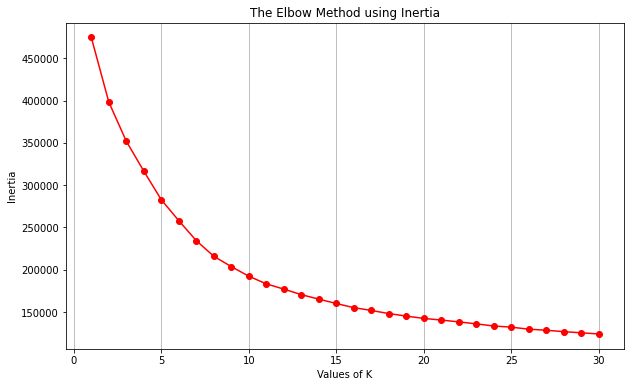

In [16]:
plt.figure(figsize=(10,6))

plt.plot(K, inertias, '-or')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')

plt.gca().xaxis.grid(True)

plt.show()

<div style="background-color:green;padding:5px; border: 5px outset red; color:yellow; font-size:1.5em; text-align:center;"><strong>Silhouette Score - if the Elbow method does not bring us an obvious result</strong>
</div>

In [17]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 30

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(features)
  labels = kmeans.labels_
  sil.append(silhouette_score(features, labels, metric = 'euclidean'))

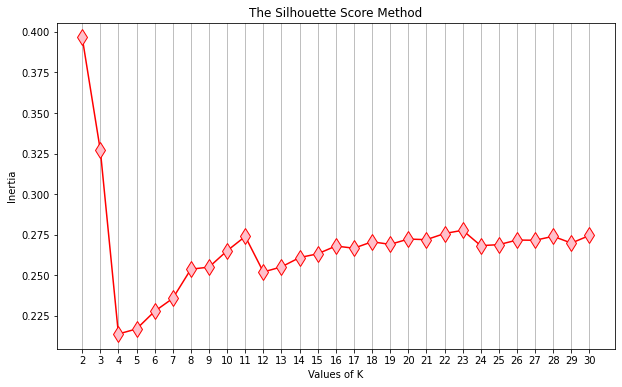

In [18]:
plt.figure(figsize=(10,6))

silrange = range(2,31)

# my_color = np.where(sil<=4, 'orange', 'skyblue')

plt.plot(silrange, sil, color='red', 
         linestyle='solid', marker='d', markerfacecolor='pink', markersize=12)

plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Silhouette Score Method')

plt.xticks(np.arange(min(silrange), max(silrange)+1, 1.0))
plt.gca().xaxis.grid(True)

plt.show()

***
Once you have identified the best number of clusters, you can apply `KMeans()` again to generate cluster label for all users.


In [19]:
cluster_labels = [None] * len(user_ids)

### _TODO: Apply KMeans() on the features with optimized n_cluster parameter after model fitting, you can find output cluster labels in `model.labels_` attribute_


In [20]:
my_kmodel = KMeans(n_clusters=4, random_state=rs).fit(features)

In [21]:
my_labels = my_kmodel.labels_

In [22]:
my_labels

array([3, 3, 3, ..., 0, 1, 1])

#### The cluster labels you generated is a list of integers indicating cluster indices. You may use the following utility method to combine the cluster labels and user ids to a dataframe, so that you know which cluster a user belongs:


In [23]:
print(len(my_labels))       # --> all labels
print(np.unique(my_labels)) # --> the four cluster indices(IDs)

#frequency of each elements:
fdist=dict(zip(*np.unique(my_labels, return_counts=True)))
sorted_fdist = sorted(fdist.items(), key=lambda x:x[1], reverse=True)
print(sorted_fdist)

33901
[0 1 2 3]
[(1, 17147), (0, 10597), (2, 4222), (3, 1935)]


In [24]:
np.unique(my_labels)

array([0, 1, 2, 3])

### now let's see which user belongs to which cluster:

In [25]:
def combine_cluster_labels(user_ids, labels):
    labels_df = pd.DataFrame(labels)
    cluster_df = pd.merge(user_ids, labels_df, left_index=True, right_index=True)
    cluster_df.columns = ['user', 'cluster']
    return cluster_df

combine_cluster_labels(user_ids, my_labels)

,user,cluster
0,2,3
1,4,3
2,5,3
3,7,1
4,8,1
...,...,...
33896,2102054,0
33897,2102356,1
33898,2102680,0
33899,2102983,1


***
### TASK: Apply PCA on user profile feature vectors to reduce dimensions

In the previous step, we applied `KMeans` on the original user profile feature vectors which have 14 original features (the course genres).


In [26]:
features = user_profile_df.loc[:, user_profile_df.columns != 'user']    # ---> all features but 'user'
user_ids = user_profile_df.loc[:, user_profile_df.columns == 'user']    # ---> only feature 'user'
feature_names = list(user_profile_df.columns[1:])                       # ---> feature names listed (excl. the 0. feature)

In [27]:
print(f"There are {len(feature_names)} features for each user profile.")

There are 14 features for each user profile.


#### If we plot a covariance matrix of the user profile feature vectors with 14 features, we can observe that some features are actually correlated:


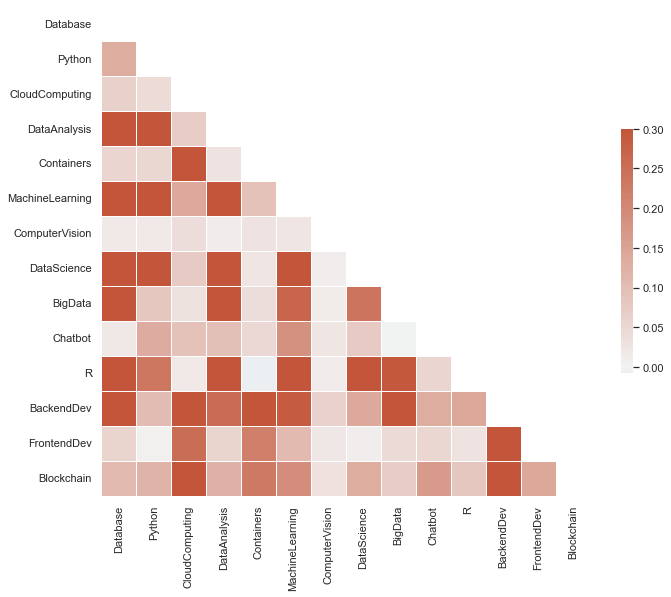

In [28]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = features.cov()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


plt.show()

#### For example, the feature `MachineLearning` and the feature `DataScience` are correlated. Such covariances among features may indicate that we can apply PCA to find its main components (eigenvectors with max eigenvalues on the covariance matrix). 

#### If we only keep the independent main components, then we can reduce the dimensions of our user profile feature vectors.

#### Now let's apply the `PCA()` provided by  `scikit-learn` to find the main components in user profile feature vectors and see if we can reduce its dimensions by only keeping the main components.


>#### <em>Note that when calling the  `PCA()` class, there is also an import argument called `n_components` which indicates how many components you want to keep in the PCA result. One way to find an optimized `n_components` is to do a grid search on a list of argument candidates (such as `range(1, 15)`) and calculate the ratio of the accumulated variance for each candidate. </em>

#### If the accumulated variances ratio of a candidate `n_components` is larger than a threshold, e.g., 90%, then we can say the transformed `n_components` could explain about 90% of variances of the original data variance and can be considered as an optimized components size.


***
### _TODO: Find the optimized `n_components` for PCA_


In [29]:
# → For a list of candidate `n_components` arguments such as 1 to 14, 
#find out the minimal `n` that can explain accumulated 90% variances of previous data

comprange = range(1,15)
pcalst_for_ncomponents = []
for x in comprange:
    pca = PCA(n_components=x)    # ---> Instantiate PCA
    pca.fit_transform(features)  # ---> Determine transformed features
    
    # Determine explained variance using explained_variance_ration_ attribute:
    exp_var_pca = pca.explained_variance_ratio_        
    
    # the sum of the above:
    accumulated_variance_ratios = sum(exp_var_pca)
    
    # Put the above values into a list to be able to check which
    #value is the smallest one which is >= 0.9
    pcalst_for_ncomponents.append(accumulated_variance_ratios)

above_thresh = {}
below_thresh = {}
for i, x in enumerate(pcalst_for_ncomponents):
    if x >= 0.9:
        above_thresh[feature_names[i]] = x
    else:
        below_thresh[feature_names[i]] = x

minvalue = min(above_thresh.values())
resultkey = [key for key in above_thresh if above_thresh[key] == minvalue]
        
print("The features equal to or above treshold 0.9:\n",above_thresh, "\n")
print("The smallest n_components has:\t",*resultkey,": ", above_thresh['BigData'])

The features equal to or above treshold 0.9:
 {'BigData': 0.9272695591307745, 'Chatbot': 0.9544658170614678, 'R': 0.9733572103164729, 'BackendDev': 0.9870310843021108, 'FrontendDev': 0.9979163166617694, 'Blockchain': 0.9999999999999999} 

The smallest n_components has:	 BigData :  0.9272695591307745


## Let's visualize the above:

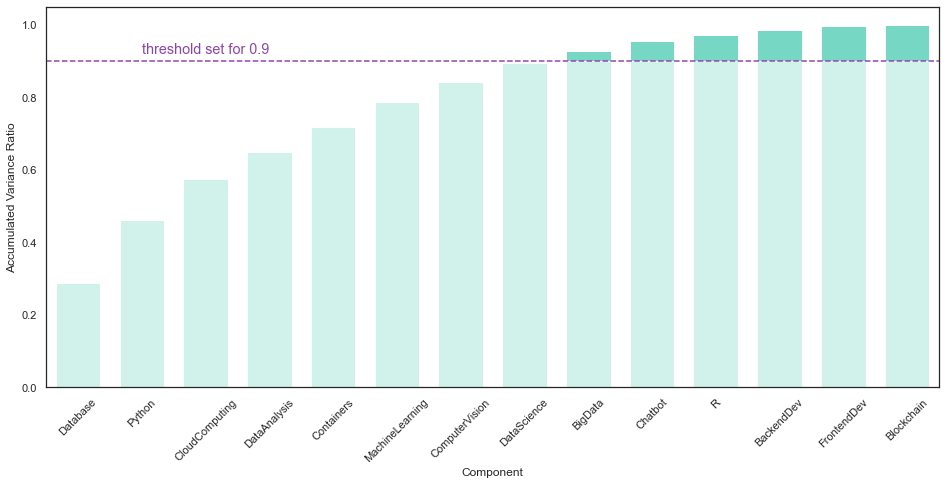

In [30]:

threshold = 0.9
values = np.array(pcalst_for_ncomponents)
x = range(1, len(values)+1)

# split it up
above_threshold = np.maximum(values - threshold, 0)
below_threshold = np.minimum(values, threshold)


# and plot it
fig, ax = plt.subplots(figsize=(16,7))
ax.bar(x, below_threshold, 0.7, color="#D1F2EB")
ax.bar(x, above_threshold, 0.7, color="#76D7C4",
        bottom=below_threshold)

# horizontal line indicating the threshold
ax.hlines(y=0.9, xmin=.5, xmax=14.5, color='#8E44AD', linestyles='dashed')
plt.text(2, 0.92, "threshold set for 0.9", color='#8E44AD', fontsize='large')

plt.xlabel('Component')
plt.ylabel('Accumulated Variance Ratio')
# plt.title('xyz')

labels = feature_names


plt.xticks(x, labels, rotation=45)
plt.xlim([1-0.5, 14+0.5])

plt.show()

#### Once you found the optimized `n_component` argument value, you can apply PCA on the user profile feature vectors and reduce the  14 features into  `n_component` features.<br>_TODO: Perform PCA to transform original user profile features_


In [31]:
print(len(below_threshold))

14


In [32]:
# - For a list of candidate `n_components` arguments such as 1 to 14, 
#find out the minimal `n` that can explain accumulated 90% variances of previous data
# - In the fitted PCA() model, you can find explained_variance_ratio_ and use 
#the sum() function to add them to get the accumulated variance ratio
# - Merge the user ids and transformed features into a new dataframe
n_components = len(below_thresh)
pca = PCA(n_components = n_components)
za = pca.fit_transform(features)
df_pca = pd.DataFrame(data=za)
df_pca.columns = ['PC'+str(col) for col in df_pca.columns.values]

result_df = pd.merge(user_ids, df_pca, left_index=True, right_index=True)
result_df.head()

,user,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,2,17.772494,0.200681,1.730609,2.567359,-3.825814,2.707154,0.681042,2.312613
1,4,7.145199,-2.847481,2.358636,-0.576654,0.398803,-0.134533,0.549769,0.469033
2,5,11.363270,1.873619,-1.522077,1.076144,-1.711688,0.883212,1.677582,2.937669
3,7,-1.834033,-0.277462,0.564905,0.053470,-0.064440,0.165757,0.030956,0.039519
4,8,-1.049125,-0.684767,1.072765,0.006371,-0.005695,0.118686,0.118559,0.559292


***
### TASK: Perform k-means clustering on the PCA transformed feature vectors


#### Now, you have the PCA  components of the original profile vectors. You can perform k-means on them again:

#### _TODO: Perform K-means on the PCA transformed features_


In [35]:
## - Apply KMeans() on the PCA features
## - Obtain the cluster label lists from model.labels_ attribute
## - Assign each user a cluster label by combining user ids and cluster labels

my_2nd_kmodel = KMeans(n_clusters=4, random_state=rs).fit(df_pca)
my_2nd_labels = my_2nd_kmodel.labels_
np.unique(my_2nd_labels)

def combine_cluster_labels(user_ids, labels):
    labels_df = pd.DataFrame(labels)
    cluster_df = pd.merge(user_ids, labels_df, left_index=True, right_index=True)
    cluster_df.columns = ['user', 'cluster']
    return cluster_df

cluster_df = combine_cluster_labels(user_ids, my_2nd_labels)
cluster_df.head(10)

,user,cluster
0,2,0
1,4,0
2,5,0
3,7,3
4,8,3
5,9,3
6,12,2
7,16,2
8,17,3
9,19,3


***
When a user is in a group or a community, it is very likely that the user will be interested in the courses enrolled by other members within the same group.

### TASK: Generate course recommendations based on the popular courses in the same cluster
<font size=4>
The Intuition of clustering-based course recommendation is very simple and can be illustrated via the following example:

Suppose a user has joined a machine learning group (via clustering algorithm). In the group, he/she finds that the top-3 courses enrolled by all other group members are `Machine Learning for Everyone`, `Machine Learning with Python`, `Machine Learning with Scikit-learn`. Since the user has already completed the `Machine Learning for Everyone` earlier, he/she decides to trust the group members' choices and enroll in other two unselected courses `Machine Learning with Python` and `Machine Learning with Scikit-learn`.


In summary, the clustering-based recommender system first groups all users based on their profiles, and maintains a popular courses list for each group. 

For any group member who needs course recommendations, the algorithm recommends the unselected courses from the popular course lists.

Next, suppose we have a set of test users, and we want to recommend new courses to them using a clustering-based recommender system:
</font>

In [36]:
test_user_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/rs_content_test.csv"
test_users_df = pd.read_csv(test_user_url)[['user', 'item']]
test_users_df.head()

,user,item
0,1502801,RP0105EN
1,1609720,CNSC02EN
2,1347188,CO0301EN
3,755067,ML0103EN
4,538595,BD0115EN


The test users dataset has only two columns, the user id and the enrolled course id.

For each user, let's find its cluster label using the k-means results you have performed in previous steps, assuming it is named `cluster_df`.

You can assign the cluster label to all test users via merging the clustering labels (`cluster_df`:):


In [37]:
test_users_labelled = pd.merge(test_users_df, cluster_df, left_on='user', right_on='user')
test_users_labelled.head()

,user,item,cluster
0,1502801,RP0105EN,0
1,1502801,BD0131EN,0
2,1502801,BD0212EN,0
3,1502801,BD0115EN,0
4,1502801,BD0211EN,0


#### From the above dataframe, we know each user's enrolled courses and its cluster index.<br>If we use a `groupby`  and `sum` aggregation, we can get the enrollments count for each course in each group, like the following code snippet:



In [38]:
courses_cluster = test_users_labelled[['item', 'cluster']]
courses_cluster['count'] = [1] * len(courses_cluster)
grouped_courses_cluster = courses_cluster.groupby(['cluster','item']).agg(enrollments = ('count','sum')).reset_index()
grouped_courses_cluster.head()

,cluster,item,enrollments
0,0,AI0111EN,2
1,0,BC0101EN,18
2,0,BC0201EN,5
3,0,BC0202EN,1
4,0,BD0101EN,57


#### _TODO: For each test user, try to recommend any unseen courses based on the popular courses in his/her cluster. You may use an enrollment count threshold (such as larger than 10) to determine if it is a popular course in the cluster_

In [39]:
limited_grouped_courses_cluster = grouped_courses_cluster[grouped_courses_cluster['enrollments'] > 10]
limited_grouped_courses_cluster.head()

,cluster,item,enrollments
1,0,BC0101EN,18
4,0,BD0101EN,57
5,0,BD0111EN,58
6,0,BD0115EN,43
7,0,BD0121EN,18


In [40]:
def reclistcreator():
    reclists = []
    for i in range(4):
        for_rec_cluster = limited_grouped_courses_cluster[limited_grouped_courses_cluster['cluster'] == i]
        for_rec_cluster = for_rec_cluster.sort_values(by='enrollments', ascending=False)
        clus_reclist = for_rec_cluster.item.to_list()
        reclists.append(clus_reclist)
        del for_rec_cluster, clus_reclist
    l1 = reclists[0]
    l2 = reclists[1]
    l3 = reclists[2]
    l4 = reclists[3]
    
    return l1, l2, l3, l4

In [41]:
reclist0, reclist1, reclist2, reclist3 = reclistcreator()

In [42]:
# first we need lists which will be the base of our dataframe
#like: user, cluster, recommendation1,2,3:
unique_userIDs = []
clusters_for_users = []
rec1 = []
rec2 = []
rec3 = []

# fill-up the user_id and cluster lists with the 'test_users_labelled' unique user's values:
for ind in test_users_labelled.index:
    usr = test_users_labelled['user'][ind]
    clus = test_users_labelled['cluster'][ind]
    if usr not in unique_userIDs:
        unique_userIDs.append(usr)
        clusters_for_users.append(clus)

        
# fill up rec1, rec2, rec3 lists:    
for i, user in enumerate(unique_userIDs):
    temp_df = test_users_labelled[test_users_labelled['user'] == user]
    list_of_courses = temp_df['item'].to_numpy()
    rec = []
        
    if clusters_for_users[i] == 0:
        ind = 0
        count = 0
        while count < 3: # now 3 is the limit, because I'll give 3 recommendations
            if reclist0[ind] not in list_of_courses and reclist0[ind] not in rec:
                rec.append(reclist0[ind])
                count += 1
            ind += 1        
                
    if clusters_for_users[i] == 1:
        ind = 0
        count = 0
        while count < 3:
            if reclist1[ind] not in list_of_courses and reclist1[ind] not in rec:
                rec.append(reclist1[ind])
                count += 1
            ind += 1
                
    if clusters_for_users[i] == 2:
        ind = 0
        count = 0
        while count < 3:
            if reclist2[ind] not in list_of_courses and reclist2[ind] not in rec:
                rec.append(reclist2[ind])
                count += 1
            ind += 1
        
    if clusters_for_users[i] == 3:
        ind = 0
        count = 0
        while count < 3:
            if reclist3[ind] not in list_of_courses and reclist3[ind] not in rec:
                rec.append(reclist3[ind])
                count += 1
            ind += 1
    
    rec1.append(rec[0]) 
    rec2.append(rec[1])
    rec3.append(rec[2])
        
recom_df = pd.DataFrame(list(zip(unique_userIDs, clusters_for_users, rec1, rec2, rec3)), 
                       columns = ['user', 'cluster', 'rec1', 'rec2', 'rec3'])

recom_df

,user,cluster,rec1,rec2,rec3
0,1502801,0,DS0101EN,PY0101EN,DS0103EN
1,1609720,2,PY0101EN,BD0101EN,DS0103EN
2,1347188,1,CO0101EN,CC0101EN,DS0101EN
3,755067,3,DS0101EN,BD0111EN,PY0101EN
4,538595,3,DS0101EN,PY0101EN,BD0211EN
...,...,...,...,...,...
995,481658,3,DS0101EN,PY0101EN,BD0211EN
996,1341273,1,BC0101EN,CC0101EN,CO0301EN
997,884271,3,DS0101EN,PY0101EN,BD0211EN
998,1868084,1,BC0101EN,CO0201EN,PY0101EN


### With the recommendation results, you also need to write some analytic code to answer the following two questions:

*  #### On average, how many new/unseen courses have been recommended to each user?<br><font color=#45B39D>In my case this question does not make any sense, because I determined above, that I'll give exactly 3 recommendations.</font>
*  #### What are the most frequently recommended courses? Return the top-10 commonly recommended courses across all users.

In [43]:
total_rec = [rec1, rec2, rec3]
# let's create a flat-list
total_rec = [item for sublist in total_rec for item in sublist]

import collections

# let's find the 10 most common elements in total_rec:
counter = collections.Counter(total_rec)
print('The 10 most common recommended courses are:\n')
print(f"{'COURSE_ID':<15}|{'REC_FREQUENCY':^18}")
print(f"{'_'*15:<15}|{'_'*18:^18}")
for x in counter.most_common(10):
    print(f'{x[0]:<15}|{x[1]:^18}')

The 10 most common recommended courses are:

COURSE_ID      |  REC_FREQUENCY   
_______________|__________________
DS0101EN       |       374        
PY0101EN       |       362        
BD0101EN       |       301        
BD0111EN       |       257        
DS0103EN       |       248        
BD0211EN       |       183        
ML0101ENv3     |       166        
DA0101EN       |       154        
DV0101EN       |       145        
BC0101EN       |       141        
